# Mosaic from a single multitemporal dataset


The goal of this notebook is to provide an example of how to create a cloud-free mosaic from Sentinel-2 imagery over a specific area over a time period. Sentinel-2 data is first loaded from a STAC API then opened as xarray DataArrays using rioxarray. This results in many overlapping scenes so it is neccesary to coregister all images to have the same CRS and resolution (reprojection and resampling). A median operation will be applied to merge the images into a cloud-free single layer that could be save off into Azure blob storage as COGs for later use.


## 1. Sentinel-2 L2A Dataset

Satellite images (also Earth observation imagery, spaceborne photography, or simply satellite photo) are images of Earth collected by imaging satellites operated by governments and businesses around the world (see https://en.wikipedia.org/wiki/Satellite_imagery). Its major applications include Earth observation and land cover monitoring. 


SENTINEL-2 (https://sentinel.esa.int/web/sentinel/user-guides/sentinel-2-msi/overview) is a wide-swath, high-resolution, multi-spectral imaging mission, supporting Copernicus Land Monitoring studies, including the monitoring of vegetation, soil and water cover, as well as observation of inland waterways and coastal areas. The SENTINEL-2 Multispectral Instrument (MSI) samples 13 spectral bands range from the visible range to the shortwave infrared (SWIR): four bands at 10 metres, six bands at 20 metres and three bands at 60 metres spatial resolution. 

The Level-1C (L1C) and Level-2A (L2A) products contain scences that defined by tiles or granules of 100x100 km2 images in UTM/WGS84 projection. Sentinel-2 L2A is generated automatically by its operational processor (Sen2Cor) using algorithms of scene classification and atmospheric correction from the L1C product. 

### Bands descripions
Below table presents band information included in a Sentinel-2 tile.

In [58]:
import pandas as pd

band_info = pd.DataFrame([
        ("B01", "Coastal Aerosol",       " 20",    0.443,  "60"),
        ("B02", "Blue",                  " 65",    0.490,  "10"),
        ("B03", "Green",                 " 35",    0.560,  "10",),
        ("B04", "Red",                   " 30",    0.665,  "10",),
        ("B05", "Vegetation Red Edge",   " 15",    0.705,  "20",),
        ("B06", "Vegetation Red Edge",   " 15",    0.740,  "20",),
        ("B07", "Vegetation Red Edge",   " 20",    0.783,  "20",),
        ("B08", "NIR",                   "115",    0.842,  "10",),
        ("B8A", "Narrow NIR",            " 20",    0.865,  "20",),
        ("B09", "Water vapour",          " 20",    0.945,  "60",),
        ("B10", "SWIR - Cirrus",         " 20",    1.375,  "60",),
        ("B11", "SWIR",                  " 90",    1.610,  "20",),
        ("B12", "SWIR",                  "180",    2.190,  "20",)],
    columns=['Band Number', 'Name', 'Bandwidth (µm)', 'Nominal Wavelength (µm)', 'Resolution (m)'])

band_info

Band Number                 Name Bandwidth (µm)  Nominal Wavelength (µm)  \
0          B01      Coastal Aerosol             20                    0.443   
1          B02                 Blue             65                    0.490   
2          B03                Green             35                    0.560   
3          B04                  Red             30                    0.665   
4          B05  Vegetation Red Edge             15                    0.705   
5          B06  Vegetation Red Edge             15                    0.740   
6          B07  Vegetation Red Edge             20                    0.783   
7          B8A           Narrow NIR             20                    0.865   
8          B09         Water vapour             20                    0.945   
9          B10        SWIR - Cirrus             20                    1.375   
10         B11                 SWIR             90                    1.610   
11         B12                 SWIR            180                    2.190   

   Resolution (m)  
0              60  
1              10  
2              10  
3              10  
4              20  
5              20  
6              20  
7              20  
8              60  
9              60  
10             20  
11             20

## 2. Environment setup

Necessary library are listed as below

In [3]:
import numpy as np
import xarray as xr
import datashader as ds
import rasterio
import pandas as pd
from datashader.transfer_functions import shade

C:\Users\mdo\Anaconda3\envs\xarray-spatial\lib\site-packages\spatialpandas\spatialindex\rtree.py:263: NumbaDeprecationWarning: The 'numba.jitclass' decorator has moved to 'numba.experimental.jitclass' to better reflect the experimental nature of the functionality. Please update your imports to accommodate this change and see https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#change-of-jitclass-location for the time frame.
  @jitclass(_numbartree_spec)


## 3. Load the Sentinel 2 data from files

##### TODO: load from a STAC API

Images being used in this example are all of product `L2A` and captured by the same satellite platform `S2A` with the same projection info.

For demonstration purpose, we choose a small study area of 2-tile width and the ingestion date starting from Jan 2021 to March 2021. 4 images at 60m resolution (correspond to 4 days of '20210103', '20210113', '20210222', '20210304') for the same scene are collected and processed. 

In [62]:
bands = ['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B8A', 'B09', 'B11', 'B12', 'SCL']
tiles = ['T15RVQ', 'T15RWQ']
dates = ['20210103', '20210113', '20210222', '20210304']
dates, tiles, bands

(['20210103', '20210113', '20210222', '20210304'],
 ['T15RVQ', 'T15RWQ'],
 ['B01',
  'B02',
  'B03',
  'B04',
  'B05',
  'B06',
  'B07',
  'B8A',
  'B09',
  'B11',
  'B12',
  'SCL'])

In [54]:
# declare tile_id
T15RVQ = 'T15RVQ'
T15RWQ = 'T15RWQ'

# dates = ['20210103', '20210113', '20210222', '20210304']
date_20210103 = '20210103'
date_20210113 = '20210113'
date_20210222 = '20210222'
date_20210304 = '20210304'

# data path
path_dict = {
    date_20210103: {
     T15RVQ: 'e:/data_sentinel2/S2A_MSIL2A_20210103T165711_N0214_R026_T15RVQ_20210103T193405.SAFE/GRANULE/L2A_T15RVQ_A028909_20210103T165709/IMG_DATA/R60m/T15RVQ_20210103T165711_%s_60m.jp2',
     T15RWQ: 'e:/data_sentinel2/S2A_MSIL2A_20210103T165711_N0214_R026_T15RWQ_20210103T193405.SAFE/GRANULE/L2A_T15RWQ_A028909_20210103T165709/IMG_DATA/R60m/T15RWQ_20210103T165711_%s_60m.jp2',
    },    
    date_20210113: {
     T15RVQ: 'e:/data_sentinel2/S2A_MSIL2A_20210113T165651_N0214_R026_T15RVQ_20210113T193819.SAFE/GRANULE/L2A_T15RVQ_A029052_20210113T165645/IMG_DATA/R60m/T15RVQ_20210113T165651_%s_60m.jp2',
     T15RWQ: 'e:/data_sentinel2/S2A_MSIL2A_20210113T165651_N0214_R026_T15RWQ_20210113T193819.SAFE/GRANULE/L2A_T15RWQ_A029052_20210113T165645/IMG_DATA/R60m/T15RWQ_20210113T165651_%s_60m.jp2',
    },
    date_20210222: {
     T15RVQ: 'e:/data_sentinel2/S2A_MSIL2A_20210222T165311_N0214_R026_T15RVQ_20210222T193217.SAFE/GRANULE/L2A_T15RVQ_A029624_20210222T165932/IMG_DATA/R60m/T15RVQ_20210222T165311_%s_60m.jp2',
     T15RWQ: 'e:/data_sentinel2/S2A_MSIL2A_20210222T165311_N0214_R026_T15RWQ_20210222T193217.SAFE/GRANULE/L2A_T15RWQ_A029624_20210222T165932/IMG_DATA/R60m/T15RWQ_20210222T165311_%s_60m.jp2',
    },
    date_20210304: {
     T15RVQ: 'e:/data_sentinel2/S2A_MSIL2A_20210304T165201_N0214_R026_T15RVQ_20210304T211533.SAFE/GRANULE/L2A_T15RVQ_A029767_20210304T170444/IMG_DATA/R60m/T15RVQ_20210304T165201_%s_60m.jp2',
     T15RWQ: 'e:/data_sentinel2/S2A_MSIL2A_20210304T165201_N0214_R026_T15RWQ_20210304T211533.SAFE/GRANULE/L2A_T15RWQ_A029767_20210304T170444/IMG_DATA/R60m/T15RWQ_20210304T165201_%s_60m.jp2',
    }
}

The code below illustrates how to read a raster from a **jp2** data file knowing the date, tile id and band id. Let's read the `Coastal Aerosol` band raster from tile `N0214_R026_T15RVQ` with the ingestion date of `20210103` using xarray.open_rasterio

In [55]:
band_01 = 'B01'
tile_id = T15RVQ
date = date_20210103

path_20210103_T15RVQ_01 = path_dict[date_20210103][T15RVQ]%band_01

agg_20210103_T15RVQ_01 = xr.open_rasterio(path_20210103_T15RVQ_01).astype(np.float)
agg_20210103_T15RVQ_01

<xarray.DataArray (band: 1, y: 1830, x: 1830)>
array([[[ 109.,  190.,  181., ...,  171.,  232.,  195.],
        [ 125.,  218.,  220., ...,  184.,  263.,  238.],
        [  99.,  204.,  214., ...,  163.,  239.,  217.],
        ...,
        [ 193.,  256.,  190., ..., 1298., 1180.,  800.],
        [ 225.,  233.,  180., ..., 1348., 1243.,  848.],
        [ 157.,  175.,  136., ..., 1141., 1077.,  752.]]])
Coordinates:
  * band     (band) int32 1
  * y        (y) float64 3.5e+06 3.5e+06 3.5e+06 ... 3.39e+06 3.39e+06 3.39e+06
  * x        (x) float64 4e+05 4.000e+05 4.001e+05 ... 5.097e+05 5.097e+05
Attributes:
    transform:   (60.0, 0.0, 399960.0, 0.0, -60.0, 3500040.0)
    res:         (60.0, 60.0)
    is_tiled:    1
    nodatavals:  (nan,)
    scales:      (1.0,)
    offsets:     (0.0,)

## 4. Coregister the images

For the same scence multitemporal data study, especially over a time series, there could be a slight shift among some images and pixels may be not perfectly aligned. Thus images need preprocessed through a co-registration approach.

An image is first read as a 3D (band, y, x) xarray DataArray. It will then be converted into a 2D aggregate by dropping the `band` dimension. After that, resampling with datashader.Canvas.raster (downsample) will be applied to make sure all images have the same shape.

####  Utilities functions

In [56]:
def convert_to_2d(agg):
    """
    Convert a 3D raster aggregate into 2D by removing band dimension.
    """    
    agg = agg.isel(band=0)
    agg = agg.drop_vars('band')
    nodata = agg.attrs['nodatavals'][0]
    agg.data[np.where(agg.data==nodata)] = np.nan
    return agg


def downsample(input_agg, sample_height=1000, sample_width=1000):
    # define a canvas for resampling
    canvas = ds.Canvas(plot_height=sample_height, plot_width=sample_width)
    # resample
    resampled_agg = canvas.raster(input_agg.astype(np.float), nan_value=np.nan)    
    
    # attributes of resampled raster remain the same as of input raster
    resampled_agg.attrs = input_agg.attrs
    
    # new resolution of resampled raster
    ycoords = input_agg.y.data
    xcoords = input_agg.x.data
    new_yres = (ycoords[0] - ycoords[-1]) / (sample_height - 1)
    new_xres = (xcoords[-1] - xcoords[0]) / (sample_width - 1)
    resampled_agg.attrs['res'] = (new_yres, new_xres)
    
    return resampled_agg


def get_data(file_path):
    # read data from a file_path
    agg = xr.open_rasterio(file_path).astype(np.float)
    # convert to 2D agg
    agg = convert_to_2d(agg)
    # downsample
    agg = downsample(agg)
    return agg

Data is stored in a nested python dictionary as below. Data are organized by date, band and tile id.

```
data_dict = {
    date_id: {
        band_id: {
            tile_id: data_array_aggregate
        }
    }
}
```

In [63]:
# take some time to run

data_dict = {}
for date in dates:
    data_dict[date] = {}
    for band in bands:
        data_dict[date][band] = {}
        for tile_id in tiles:
            # get the data path                        
            file_path = path_dict[date][tile_id]%band
            data_dict[date][band][tile_id] = get_data(file_path)

## Combine tiles into one DataArray

In this step, tiles are combined together by date and by band in order to form a full scence of the study area. We have many sub-images with overlapping xcoords and ycoords. In order to combine them in both 2 dimensions, we can use function combine_nested from xarray (http://xarray.pydata.org/en/stable/generated/xarray.combine_nested.html). This requires the datasets to be in the order that we wish them to be concatenated.

The grid is defined as ```[[T15RVQ, T15RWQ]]```. 

Let's combine the all images of `Coastal Aerosol` band for the date `20210103`

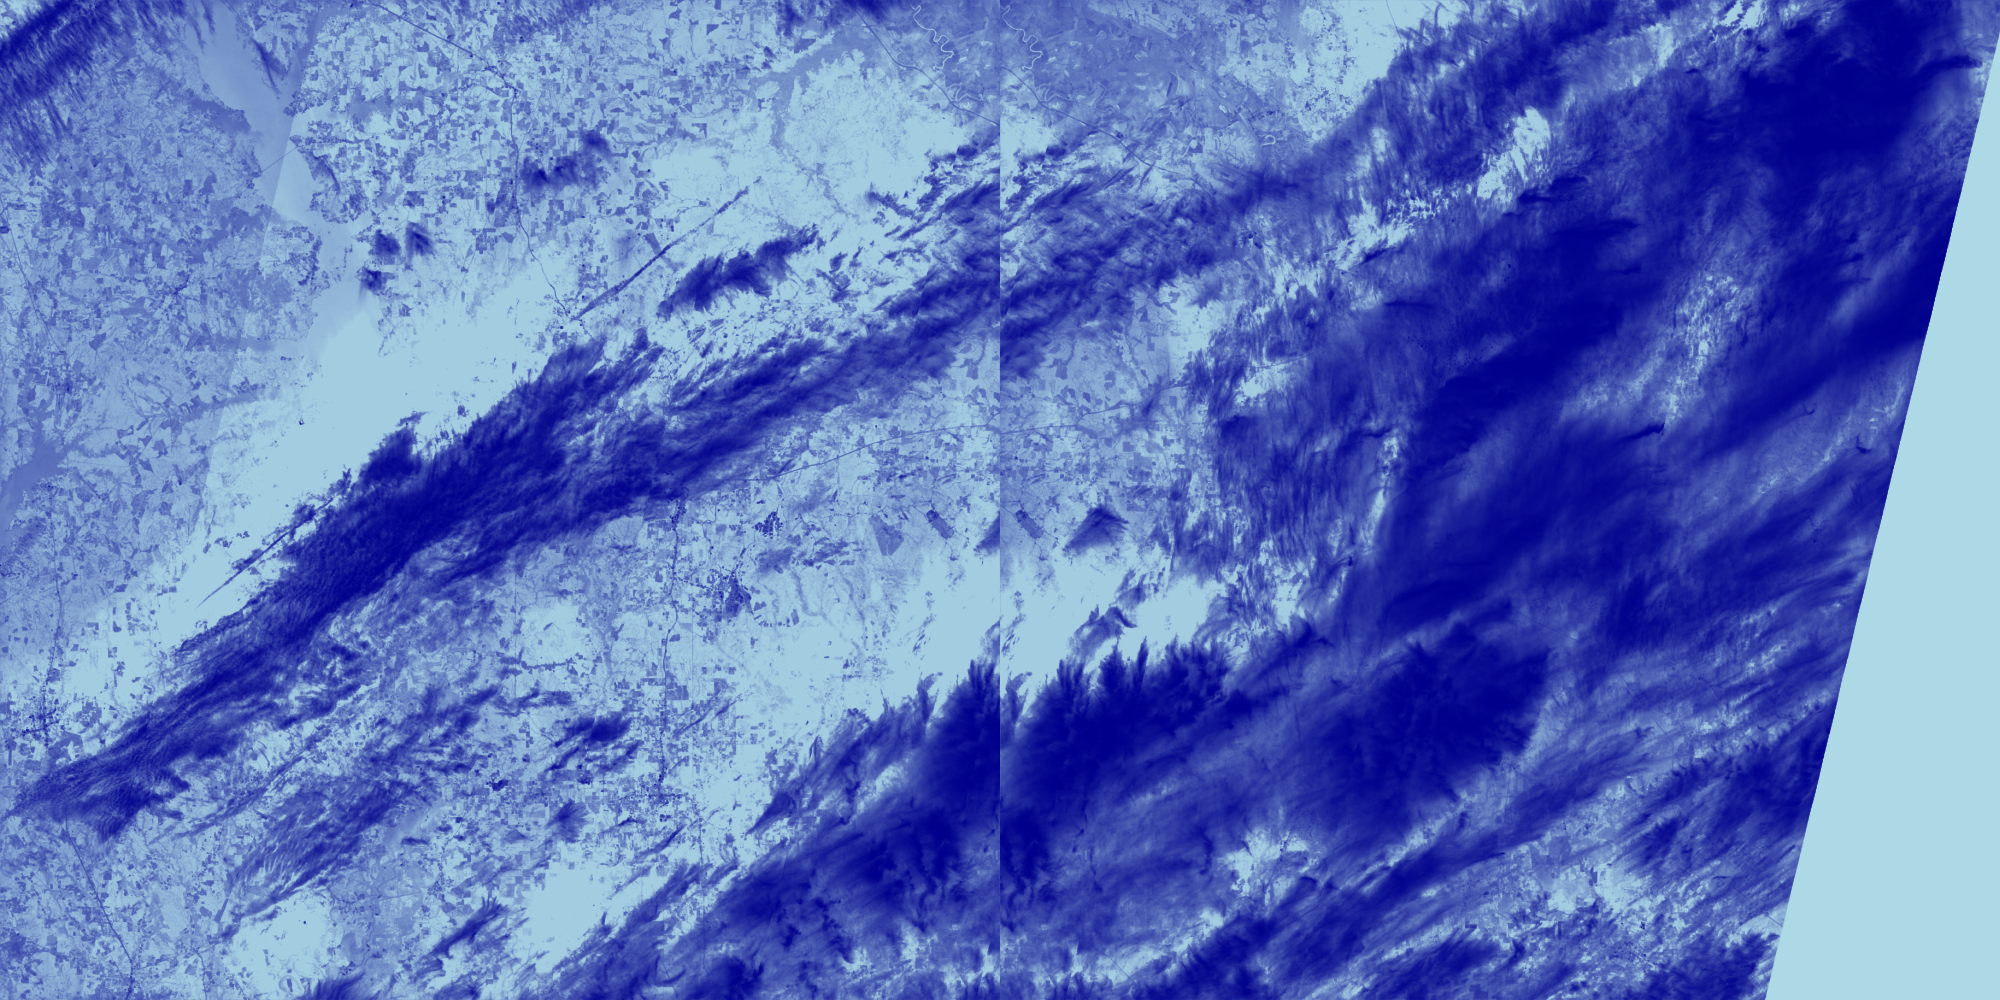

In [66]:
band_01 = 'B01'
grid_20210103_01 = [
    [ data_dict[date_20210103][band_01][T15RVQ], data_dict[date_20210103][band_01][T15RWQ] ]
]

combined_20210103_01 = combine(grid_20210103_01) 
shade(combined_20210103_01.compute())

Let's do the same thing for all other dates and all other bands. Similar as before, the combined data is also stored in a nested dictionary:

```
band_data_dict = {
    date: {
        band_id: combined_agg
    }
}
```

In [67]:
band_data_dict = {}
for date in dates:
    band_data_dict[date] = {}    
    for band in bands:
        grid_band = [
            [ data_dict[date][band][T15RVQ], data_dict[date][band][T15RWQ] ]
        ]
        band_data_dict[date][band] = combine(grid_band)

In [43]:
import xrspatial.multispectral as ms
import importlib

importlib.reload(ms)

# arvi_agg = ms.arvi(band_data_dict['08'], band_data_dict['04'], band_data_dict['03'])
# shade(arvi_agg.compute())

<module 'xrspatial.multispectral' from 'd:\\thuydo\\upwork\\makepath\\xarray-spatial\\xrspatial\\multispectral.py'>

## 5. Mosaic cloud-free scene

## 6. Save to Azure blob storage as COGs